In [1]:
import pandas as pd
import numpy as np
import random
data=pd.read_csv("FAOLEX.csv")
print(data.keys())
np.random.seed(69)
random.seed(69)

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [2]:
# remve repealed legislation
data["Repealed"].fillna(value = "N", inplace=True)
data["Repealed"] = pd.Categorical(data["Repealed"])
data=data[data["Repealed"]=="N"]


In [948]:
#data = data[data["Type of text"]=="Legislation"]

In [3]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1




In [4]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])




In [865]:
# Ignore
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [1077]:
print(keywords[15])
print(stemmed_words[15])


['maritime zone', ' EEZ-Exclusive Economic Zone', ' continental shelf']
['transport/storag', ' fish product', ' authorization/permit', ' institut', ' sub-national agr']


# Top2vec topic model

In [5]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


/Users/gustavnielsen/Documents/Fagprojekt-1/top2vec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-15 15:00:04,445 - top2vec - INFO - Pre-processing documents for training
2023-06-15 15:00:10,484 - top2vec - INFO - Creating joint document/word embedding
2023-06-15 15:02:48,089 - top2vec - INFO - Creating lower dimension embedding of documents
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-06-15 15:04:33,665 - top2vec - INFO - Finding dense areas of documents
2023-06-15 15:04:38,988 - top2vec - INFO - Finding topics


In [6]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([1242, 1179, 1148, ...,   20,   19,   19])

In [7]:
model.get_num_topics()

1040

In [1436]:
topic_words,word_scores,topic_nums = model.get_topics(5)

In [577]:
#print(topic_words)

In [1545]:
# Find documents most similar to a specific topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=110, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 26793, Score: 0.9697257876396179
-----------
marine fisheries fishing gear/fishing method marine fishes prohibited fishing area protected fishing area fishing authorization fishery management and conservation
-----------

Document: 11724, Score: 0.9678041338920593
-----------
marine fisheries prohibited fishing area seasons fishery management and conservation
-----------

Document: 16254, Score: 0.9669398665428162
-----------
marine fisheries fishing gear/fishing method prohibited fishing area fishery management and conservation
-----------

Document: 66867, Score: 0.966924786567688
-----------
marine fisheries fishing area prohibited fishing area fishery management and conservation
-----------

Document: 41749, Score: 0.9643895030021667
-----------
inland fisheries prohibited fishing area fishery management and conservation
-----------

Document: 7723, Score: 0.9640620350837708
-----------
marine fisheries fishery management and conservation prohibited fishing area
---------

In [871]:
# Check documents
data.iloc[370]

Record Id                                                     LEX-FAOC001981
Record URL                 http://www.fao.org/faolex/results/details/en/c...
Document URL                     https://faolex.fao.org/docs/pdf/gui1981.pdf
Title                      Arrêté nº 015/MARA/CAB/90 d'application du déc...
Original title                                                           NaN
Date of original text                                             25-04-1990
Last amended date                                                        NaN
Available website                                                        NaN
Language of document                                                  French
Country/Territory                                                     Guinea
Regional organizations                                                   NaN
Territorial subdivision                                                  NaN
Type of text                                                      Regulation

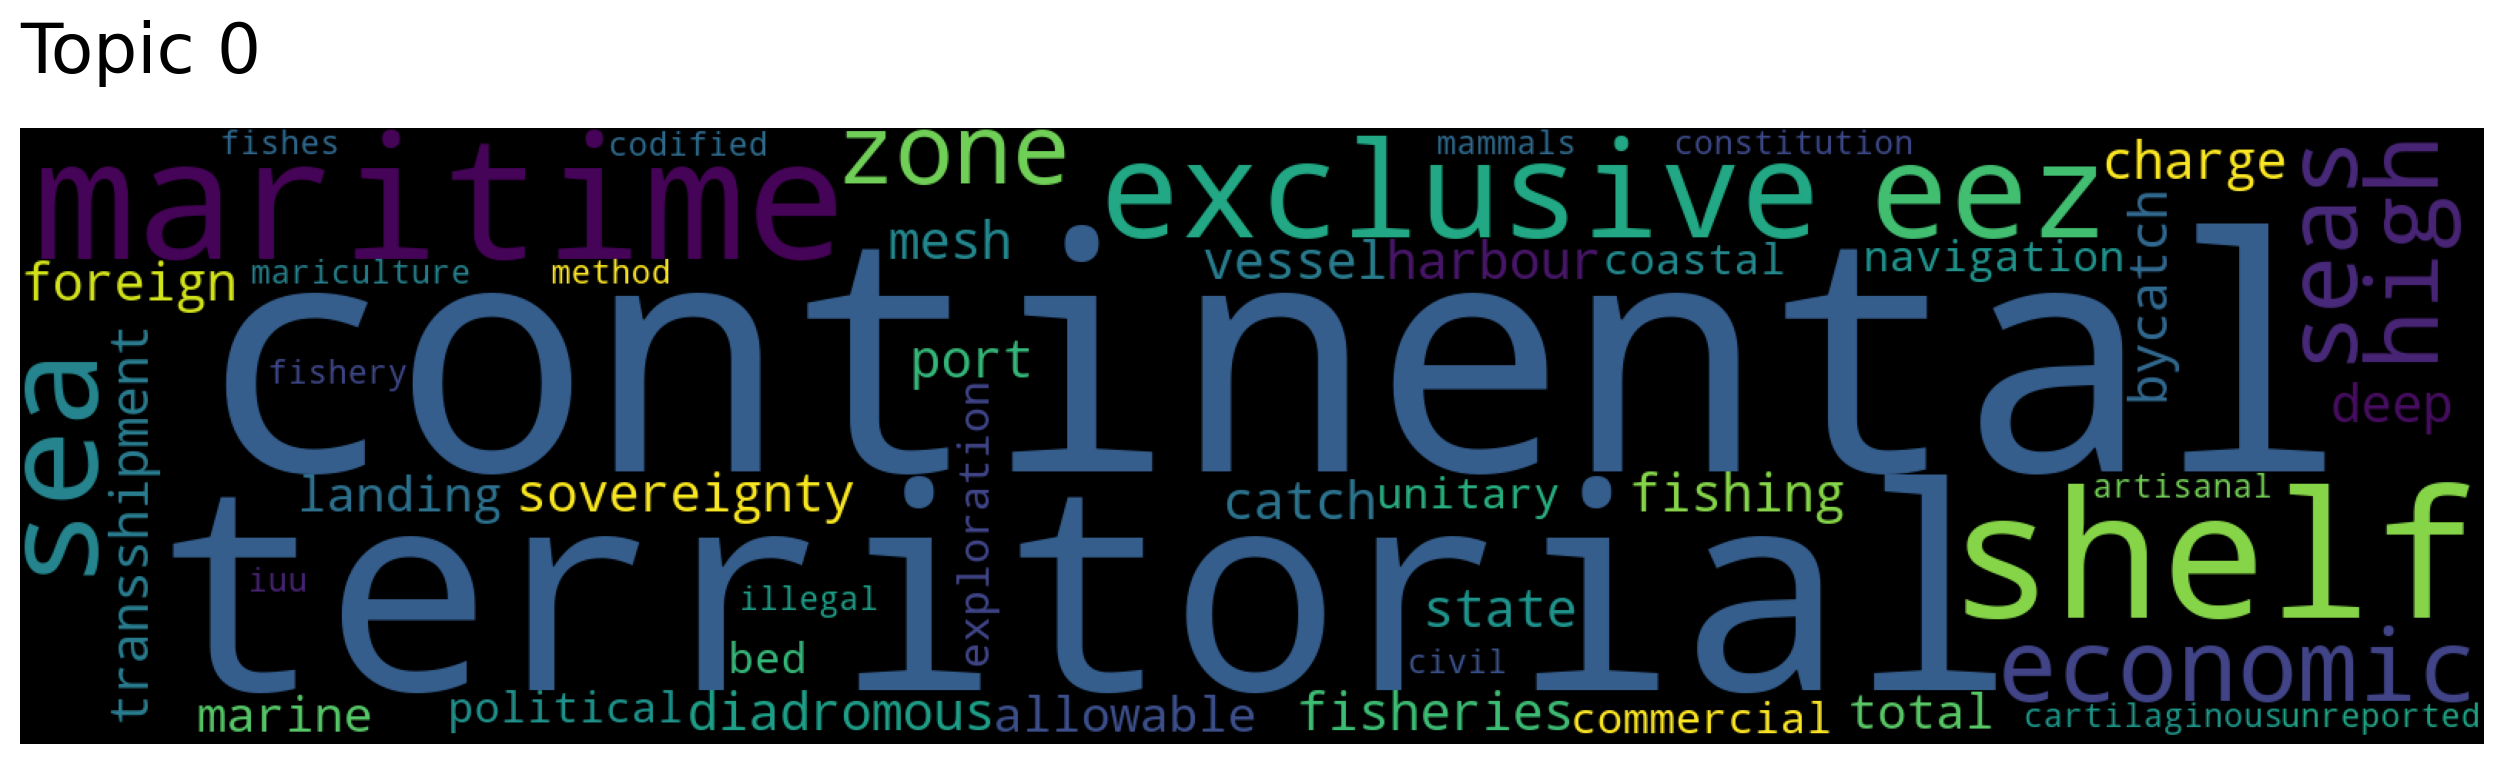

In [8]:
model.generate_topic_wordcloud(0,reduced=False)

In [1037]:
# Look up topics corresponding to a keyword
#topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["waste"], num_topics=10)
#print(topic_words)
#print(topic_nums)
#print(topic_scores)

# Load model

In [10]:
model.save("top2vec_model")

In [ ]:
newmodel = Top2Vec.load("top2vec_model")

# Topic reduction

In [1520]:
# Reduce number of topics to n
n=150
topic_mapping = model.hierarchical_topic_reduction(num_topics=n)


In [14]:
# Reduce number of countries
reduced=False

In [1522]:
model.get_num_topics(reduced=True)
#print(model.topic_words_reduced)

150

# Classifier

In [1523]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
feature_vectors = []
country_all = []
for i in (range(len(country))):
    if len(country[i].split("; "))>=2:
        for j in range(len(country[i].split("; "))):
            topic_nums,topic_score,_,_ = model.get_documents_topics([i], reduced=reduced, num_topics=model.get_num_topics(reduced=reduced))
            feature_vectors.append(topic_score[0][topic_nums[0].argsort()])
            country_all.append(country[i].split("; ")[j])
    else:
        topic_nums,topic_score,_,_ = model.get_documents_topics([i], reduced=reduced, num_topics=model.get_num_topics())
        feature_vectors.append(topic_score[0][topic_nums[0].argsort()])
        country_all.append(country[i])

In [1524]:
labels = country_all

# Encode labels in order to use frame in a classication framework
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [1525]:
# Make train/test split
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, encoded_labels, test_size = 0.2)

In [1532]:
# Make KNN classifier 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=12)
neigh.fit(X_train, y_train)
y_pred_knn = neigh.predict(X_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_knn))

ACCURACY OF THE MODEL:  0.18690649089487207


## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [11]:
# Compute uniqe countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [1292]:
#View all countries
#set(country_new)

In [12]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1


In [15]:
# Compute country x topic occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)
country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num],reduced=reduced)
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1



In [16]:

 
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

#Standardisering
#for i in range(len(countries)):
 #   country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i]) 


In [17]:
def square_rooted(x):
        return np.sqrt(sum([a*a for a in x]))
def co_occurence(country_new,similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))
        
    return country_co_occurrence

country_co_occurrence = co_occurence(country_new,"correlation")
np.shape(country_co_occurrence)

(257, 257)

In [18]:
#Remove small islands

for i in range(len(set(country_new))):
    if country_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

# Country Network

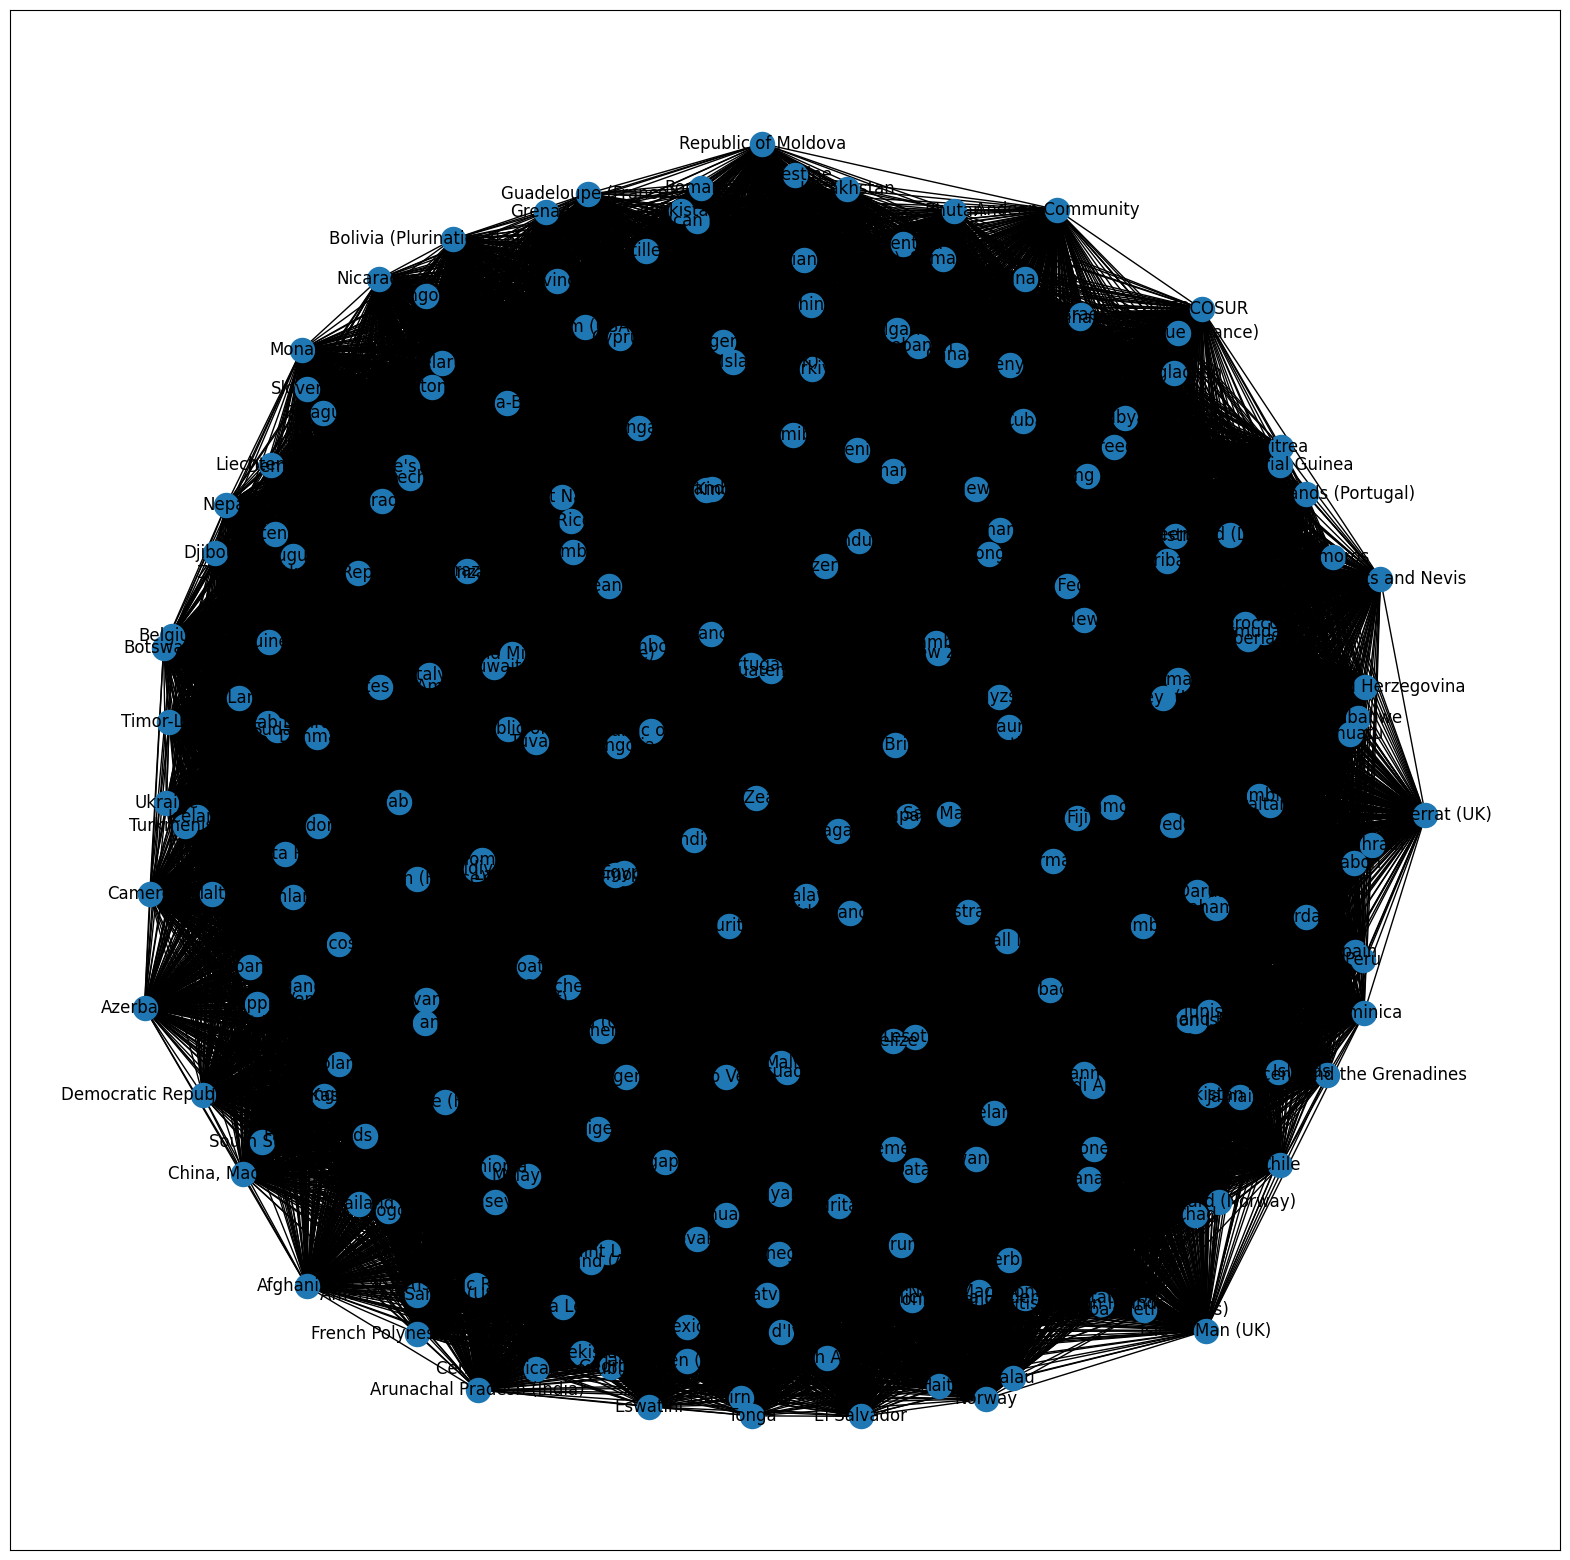

In [19]:
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt
countries_swap_copy = countries_swap.copy()

G = nx.Graph()

size = country_co_occurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])
# Remove small isalnds
for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(20, 20))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

In [20]:
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.3,seed=69)
unique_coms = np.unique(list(comms))

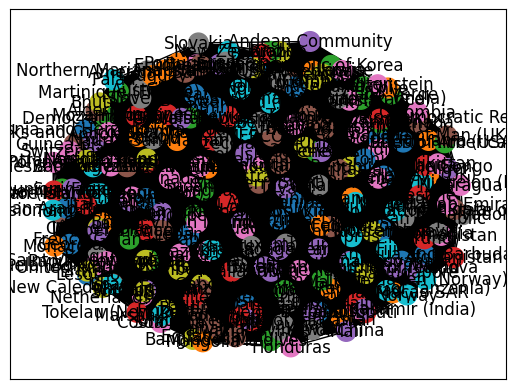

In [21]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap_copy)
plt.show()


In [22]:
from networkx.algorithms.community import louvain_communities
resolution=[0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]
scores=np.zeros(len(resolution))
j=0
for res in resolution:
    comms = louvain_communities(G,weight="weight",resolution=res,seed=69)
    unique_coms = np.unique(list(comms))
    i=1
    communities={}
    for community in comms:
        #print("c",i)
        com_countries = []
        for c in community:
            #print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1
    for com in communities.values():
        if len(com)==1:
            scores[j]+=1
        elif len(com)>=30:
            scores[j]+=len(com)-29
    j+=1

In [56]:
res_op=np.argmin(scores)
comms = louvain_communities(G,weight="weight",resolution=resolution[1],seed=69)
unique_coms = np.unique(list(comms))
i=1
communities={}
for community in comms:
        print("c",i)
        com_countries = []
        for c in community:
            print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1

c 1
Djibouti
Botswana
Algeria
Zimbabwe
Mauritania
Madeira Islands (Portugal)
Gabon
Lesotho
Malawi
Congo
Namibia
Sudan
Brunei Darussalam
Albania
Zanzibar (United Republic of Tanzania)
Pakistan
Bangladesh
India
Rwanda
Kenya
Tunisia
Lao People's Democratic Republic
Sri Lanka
Nigeria
Niger
Mozambique
Puerto Rico (USA)
Zambia
Arunachal Pradesh (India)
Timor-Leste
Cabo Verde
Angola
Democratic Republic of the Congo
Guinea
Togo
Benin
Central African Republic
Brazil
Senegal
Paraguay
Côte d'Ivoire
Nepal
Burkina Faso
Uganda
Bhutan
Eswatini
Ghana
Cambodia
Cameroon
South Sudan
Palestine
Afghanistan
Haiti
Bolivia (Plurinational State of)
Madagascar
Mali
Jammu and Kashmir (India)
United Republic of Tanzania
Chad
Ethiopia
Iraq
Burundi
c 2
Saint Helena, Ascension and Tristan da Cunha (UK)
Somalia
Guyana
Mayotte (France)
United States of America
Barbados
Myanmar
Saint Kitts and Nevis
Antigua and Barbuda
Mauritius
Trinidad and Tobago
Réunion (France)
Bahamas
Guadeloupe (France)
Maldives
Saint Pierre and 

In [53]:
# Ekstra for comparison between the Top2vec and LDA model
res_op=np.argmin(scores)
comms = louvain_communities(G,weight="weight",resolution=resolution[res_op],seed=69)
unique_coms = np.unique(list(comms))
i=1
communities2={}
for community in comms:
        #print("c",i)
        com_countries = []
        for c in community:
            #print(countries_swap[c])
            com_countries.append(countries_swap[c])
        communities2[i] = com_countries
        i=i+1

In [1215]:
%store -r communities3

In [1328]:
set(communities3[2])

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Burundi',
 'Iran (Islamic Republic of)',
 'Jordan',
 'Kazakhstan',
 'Kyrgyzstan',
 'Mongolia',
 'Romania',
 'Tajikistan',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

In [1329]:
set(communities2[5])

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Hungary',
 'Kazakhstan',
 'Kyrgyzstan',
 'Lithuania',
 'Mongolia',
 'Republic of Moldova',
 'Romania',
 'Russian Federation',
 'Tajikistan',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

In [1336]:
N_confusion = np.zeros((len(communities2),len(communities3)))

for i in range(len(communities2)):
    for j in range(len(communities3)):
        N_confusion[i,j]=int(len(list(set(communities2[i+1])&set(communities3[j+1]))))

In [1340]:
df = pd.DataFrame (N_confusion)

df.to_excel('confusion_matrix.xlsx', index=False)

In [1476]:
# compute similartiy between countries:
#WIP
c1 = ["Pakistan","India"]
#print(country_topic_matrix[countries["Pakistan"],:])
#print(country_topic_matrix[countries["India"],:])
#print(country_co_occurrence[countries["Pakistan"],countries["India"]])
for i in range(250):
    if country_co_occurrence[countries["Pakistan"],i] >=0.3:
        #print(i,country_co_occurrence[countries["Pakistan"],i])

IndentationError: expected an indented block (3328864067.py, line 9)

## Compare communities to income

In [24]:
import pandas as pd
#country data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

Index(['Economy', 'Code', 'Region', 'Income group', 'Lending category',
       'Other (EMU or HIPC)'],
      dtype='object')


In [25]:

income_countries = list(income["Economy"])
income_groups = list(income["Income group"])
income_listed_countries =[]
countries_income_dic ={}
for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            income_listed_countries.append(j)
            if income_groups[i] == "Low income":
                countries_income_dic[j]= 0
            elif income_groups[i] == "Lower middle income":
                countries_income_dic[j]= 1
            elif income_groups[i] == "Upper middle income":
                countries_income_dic[j]= 2
            elif income_groups[i] == "High income":
                countries_income_dic[j]= 3
missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in income_listed_countries:
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])


In [26]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_income_countries_names:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

/Users/gustavnielsen/Documents/Fagprojekt-1/top2vec/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Match: Netherlands (Kingdom of the) - Netherlands
Match: Juan de Nova Island (France) - France
Match: Mayotte (France) - France
Match: United States of America - United States
Match: Congo - Congo, Dem. Rep.
Match: Saint Kitts and Nevis - St. Kitts and Nevis
Match: Zanzibar (United Republic of Tanzania) - Tanzania
Match: China, Macao SAR - Macao SAR, China
Match: Réunion (France) - France
Match: Tromelin Island (France) - France
Match: Bahamas - Bahamas, The
Match: Guadeloupe (France) - France
Match: Puerto Rico (USA) - Puerto Rico
Match: Saint Pierre and Miquelon (France) - France
Match: Gibraltar (UK) - Gibraltar
Match: Northern Mariana Islands (USA) - Northern Mariana Islands
Match: American Samoa (USA) - American Samoa
Match: Glorioso Island (France) - France
Match: Côte d'Ivoire - Côte d’Ivoire
Match: Åland Islands (Finland) - Finland
Match: Faroe Islands (Denmark) - Denmark
Match: French Guiana (France) - France
Match: Niue (New Zealand) - New Zealand
Match: Republic of Moldova -

In [27]:

for i,j in matches:
    if income_groups[income_countries.index(j)] == "Low income":
        countries_income_dic[countries[i]]= 0
    elif income_groups[income_countries.index(j)] == "Lower middle income":
        countries_income_dic[countries[i]]= 1
    elif income_groups[income_countries.index(j)] == "Upper middle income":
        countries_income_dic[countries[i]]= 2
    elif income_groups[income_countries.index(j)] == "High income":
        countries_income_dic[countries[i]]= 3


missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in countries_income_dic.keys():
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [28]:
extra_countries = [('Saint Barthélemy (FRA)',3),('Kyrgyzstan',1),('Andean Community',2),('Palestine',1),('Iran (Islamic Republic of)',1),('Slovakia',3),('Saint Helena, Ascension and Tristan da Cunha (UK)',3),('Jersey  (UK)',3),('Montserrat (UK)',3),('European Union',3),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',3),
('Anguilla (UK)',3),('Cook Islands',3),('Micronesia (Federated States of)',1),('Republic of Korea',3),('MERCOSUR',2),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',2),('Pitcairn (UK)',3),("Lao People's Democratic Republic",1)]


for i,j in extra_countries:
    countries_income_dic[countries[i]]= j


In [29]:
# Compare countries income: function takes a list of country indexes and returns the rang between lowest and higest income country and the standard deviation
def check_income(community):
    com_income = []
    for i in community:
        com_income.append(countries_income_dic[i])
    range = max(com_income)-min(com_income)
    std = np.std(com_income)
    return range, std
    

    

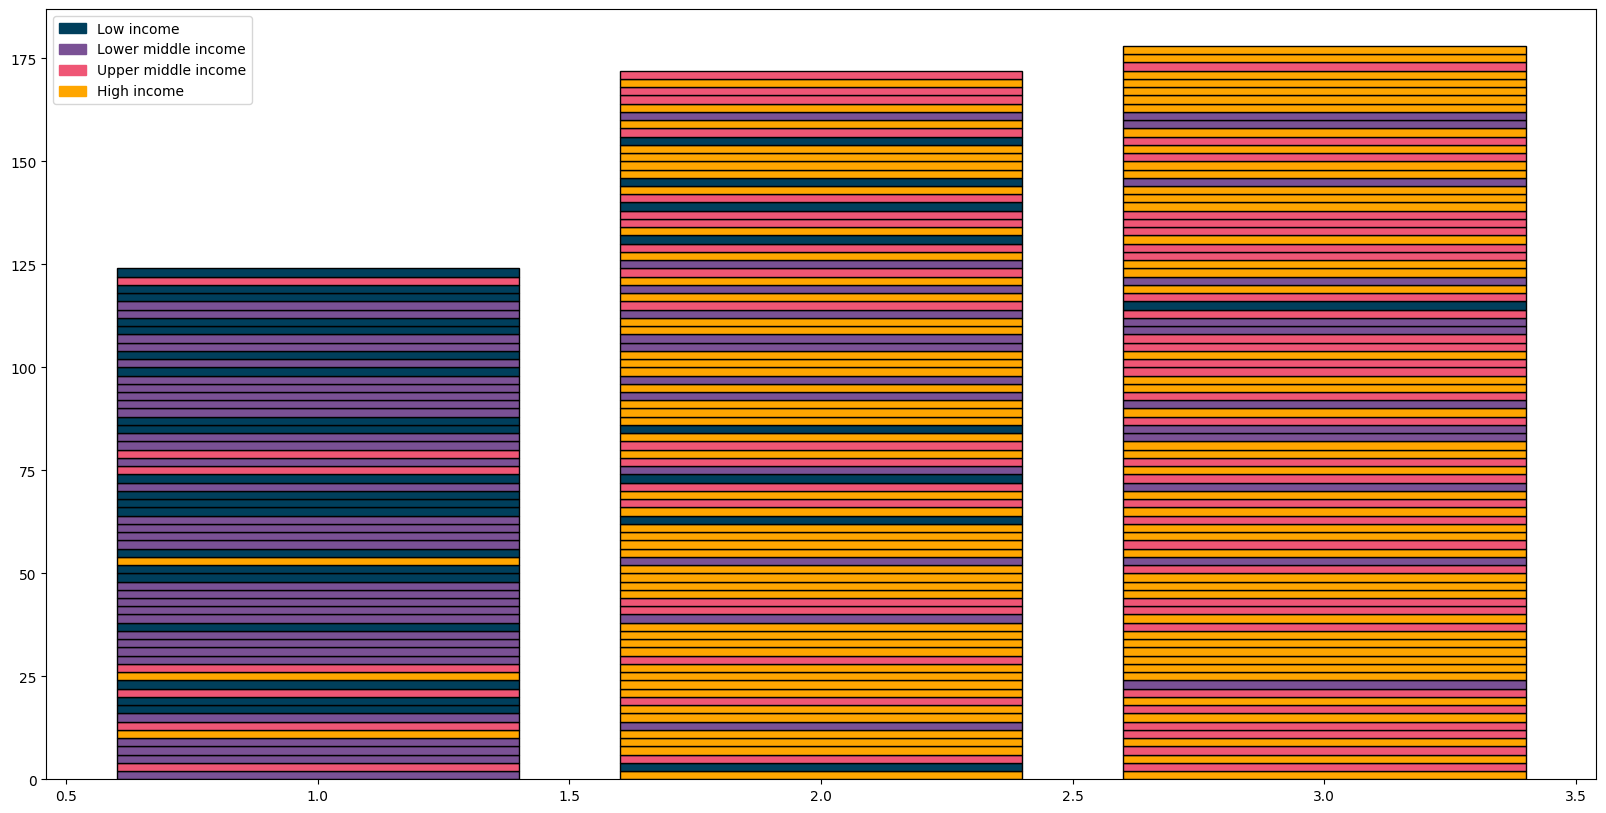

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            h=2
        else:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Low income")
pop_b = mpatches.Patch(color='#7a5195', label="Lower middle income")
pop_c = mpatches.Patch(color='#ef5675', label="Upper middle income")
pop_d = mpatches.Patch(color='#ffa600', label='High income')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])



In [37]:
for c in communities[9]:
    print(countries_swap[c],countries_income_dic[c])

Djibouti 1
Algeria 1
Angola 1
Democratic Republic of the Congo 0
Guinea 0
Togo 0
Benin 1
Mauritania 1
Central African Republic 0
Senegal 1
Gabon 2
Côte d'Ivoire 1
Burkina Faso 0
Congo 0
Albania 2
Cameroon 1
Tunisia 1
Madagascar 0
Mali 0
Niger 0
Mozambique 0
Chad 0
Timor-Leste 1
Burundi 0


In [38]:
print("Number of countries in different income groups + proportion")
print("Low: ",income_groups.count("Low income"),income_groups.count("Low income")/len(income_groups))
low_p = income_groups.count("Low income")/len(income_groups)
print("Lower middle: ",income_groups.count("Lower middle income"),income_groups.count("Lower middle income")/len(income_groups))
lowermiddle_p = income_groups.count("Lower middle income")/len(income_groups)
print("Upper middle: ",income_groups.count("Upper middle income"),income_groups.count("Upper middle income")/len(income_groups))
uppermiddle_p = income_groups.count("Upper middle income")/len(income_groups)
print("High: ",income_groups.count("High income"),income_groups.count("High income")/len(income_groups))
high_p = income_groups.count("High income")/len(income_groups)

Number of countries in different income groups + proportion
Low:  28 0.10566037735849057
Lower middle:  54 0.2037735849056604
Upper middle:  54 0.2037735849056604
High:  81 0.30566037735849055


In [1402]:
# Make permutation test
observed_income =[]
observed_community = []
for i in range(len(communities)):
     for c in communities[i+1]:
        observed_income.append(countries_income_dic[c])
        observed_community.append(i+1)
# Dsitribtuion prior to permutation (proportion of high income)
def count_community_3(communities, numbers):
    count_array = np.zeros(len(communities))  # Dictionary to store the count of each community
    community_count = np.zeros(len(communities))
    # Iterate over the communities and numbers lists
    for community, number in zip(communities, numbers):
        if number == 3:
            count_array[community-1]+=1
        community_count[community-1]+=1
    return count_array,community_count

og_scores = []
prop_high,community_count=count_community_3(observed_community,observed_income)
for community, count, total_count in zip(communities,prop_high,community_count):
    #print(f"Community {community} has {count/total_count} % of high income.")
    og_scores.append(count/total_count)




In [878]:
import random
permuted_scores=[]
prop_high,community_count=count_community_3(observed_community,observed_income)
for community, count, total_count in zip(communities,prop_high,community_count):
    #print(f"Community {community} has {count/total_count} % of high income.")
    permuted_scores.append(count/total_count)




In [852]:
a=observed_community
a

1

# Governance

In [39]:
#country governance data
governance = pd.read_excel("governence data update.xlsx")
print(governance.keys())
governance_country = []
categorized_governance = []

for est,c in zip(governance["Estimate"],governance["Country/Territory"]):
    if est >=1:
        categorized_governance.append(3)
        governance_country.append(c)
    elif est>=0 and est<1:
        categorized_governance.append(2)
        governance_country.append(c)
    elif est>-1 and est<0:
        categorized_governance.append(1)
        governance_country.append(c)
    elif est<=-1:
        categorized_governance.append(0)
        governance_country.append(c)
        

Index(['Country/Territory', 'Estimate'], dtype='object')


In [40]:
#income_countries = list(income["Economy"])
#income_groups = list(income["Income group"])
governance_listed_countries =[]
governance_dic={}
for i in range(len(governance_country)):
    for j in range(len(countries_swap)):
        if governance_country[i] == countries_swap[j]:
            governance_listed_countries.append(j)
            governance_dic[j]=categorized_governance[i]
missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_listed_countries:
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [41]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_gov_countries_names:
    best_match = process.extractOne(country1, governance_country)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

Match: Netherlands (Kingdom of the) - Netherlands
Match: Juan de Nova Island (France) - France
Match: Mayotte (France) - France
Match: United States of America - United States
Match: Congo - Congo, Rep.
Match: Saint Kitts and Nevis - St. Kitts and Nevis
Match: Zanzibar (United Republic of Tanzania) - Tanzania
Match: China, Macao SAR - Macao SAR, China
Match: Réunion (France) - France
Match: Tromelin Island (France) - France
Match: Bahamas - Bahamas, The
Match: Guadeloupe (France) - France
Match: Puerto Rico (USA) - Puerto Rico
Match: Saint Pierre and Miquelon (France) - France
Match: American Samoa (USA) - American Samoa
Match: Glorioso Island (France) - France
Match: Åland Islands (Finland) - Finland
Match: Faroe Islands (Denmark) - Denmark
Match: French Guiana (France) - France
Match: Niue (New Zealand) - Niue
Match: Republic of Moldova - Moldova
Match: Martinique (France) - France
Match: Egypt - Egypt, Arab Rep.
Match: Jammu and Kashmir (India) - India
Match: South Georgia and the S

In [42]:
for i,j in matches:
    governance_dic[countries[i]]=categorized_governance[governance_country.index(j)]

missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_dic.keys():
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [43]:
# Extra countries, 5 = Nan
extra_countries = [('Saint Barthélemy (FRA)',5),("Isle of Man (UK)",5),('Kyrgyzstan',1),('Andean Community',5),('Palestine',0),('Iran (Islamic Republic of)',0),('Slovakia',2),("Curaçao",5),('Saint Helena, Ascension and Tristan da Cunha (UK)',5),('Jersey  (UK)',3),('Montserrat (UK)',3),("Bermuda (UK)",5),("Cabo Verde",5),('European Union',5),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',5),
('Anguilla (UK)',5),('Cook Islands',3),('Micronesia (Federated States of)',3),('Republic of Korea',2),("Northern Mariana Islands (USA)",3),('MERCOSUR',5),("British Virgin Islands (UK)",5),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',0),('Pitcairn (UK)',3),("Lao People's Democratic Republic",0),("Turks and Caicos Islands (UK)",5),("Gibraltar (UK)",5),
("Taiwan Province of China",3),("South Georgia and the South Sandwich Islands (UK)",5)]


for i,j in extra_countries:
    governance_dic[countries[i]]= j


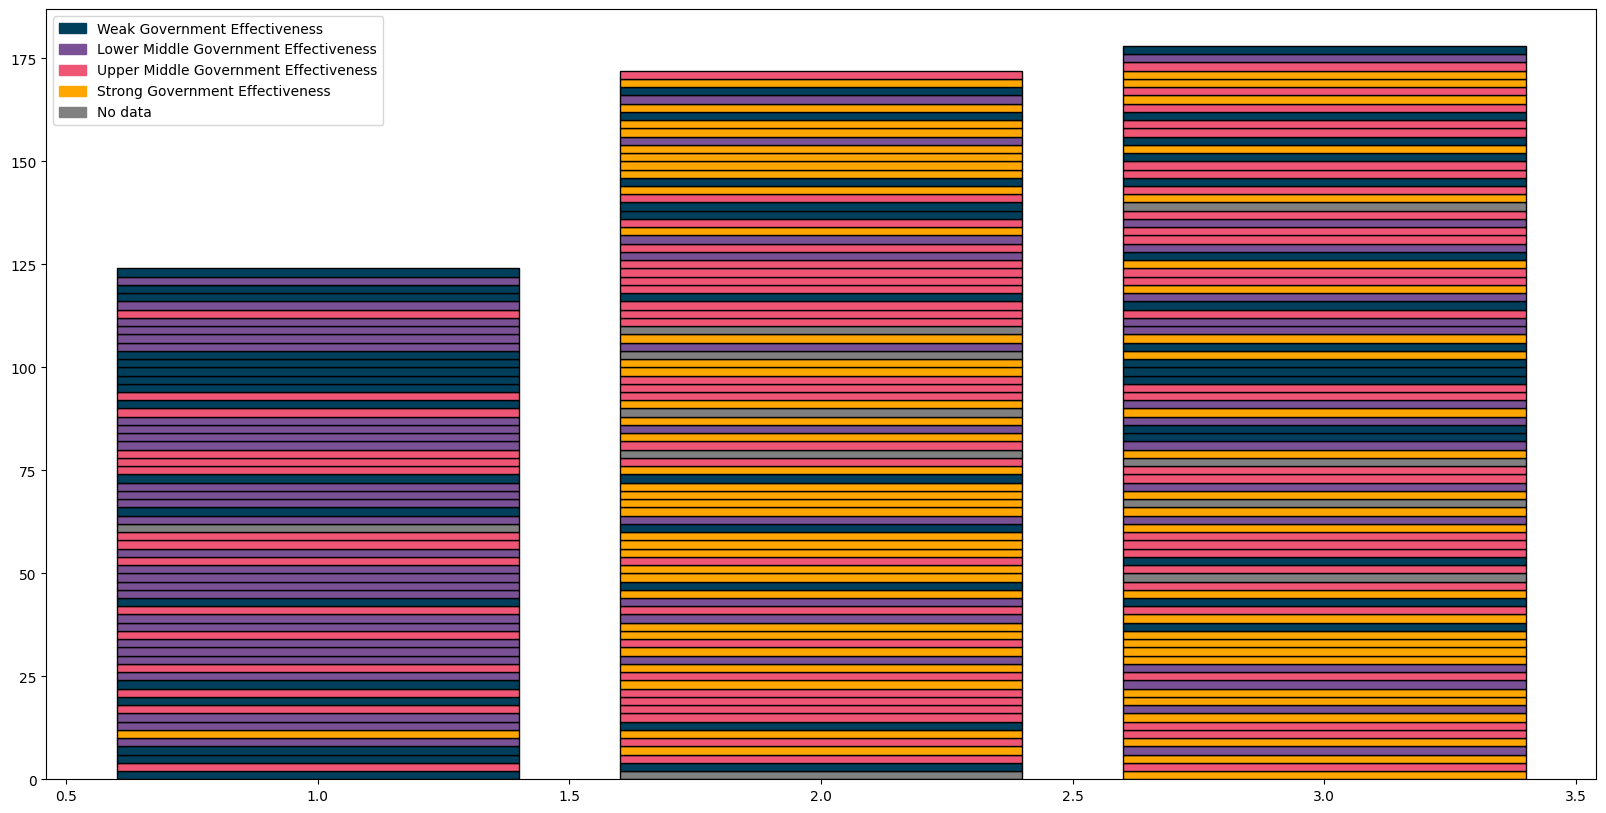

In [58]:
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 2, color="#808080",width=0.8,edgecolor="#000000")
            h=2
        else:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 2, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Weak Government Effectiveness")
pop_b = mpatches.Patch(color='#7a5195', label="Lower Middle Government Effectiveness")
pop_c = mpatches.Patch(color='#ef5675', label="Upper Middle Government Effectiveness")
pop_d = mpatches.Patch(color='#ffa600', label='Strong Government Effectiveness')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])

In [46]:
for c in communities[26]:
    print(countries_swap[c],governance_dic[c])

Pitcairn (UK) 3
Somalia 0
Netherlands Antilles (Netherlands) 3
Thailand 1
Tokelau (New Zealand) 3
Libya 0
Solomon Islands 2
Faroe Islands (Denmark) 3
Nauru 2
Papua New Guinea 2
Japan 3
Niue (New Zealand) 3
Aruba (Netherlands) 3
Palau 3
Iceland 3
Turks and Caicos Islands (UK) 5
Sweden 3
Cook Islands 3
Kiribati 3
British Virgin Islands (UK) 5
Sao Tome and Principe 2
Maldives 1
Equatorial Guinea 0
Tuvalu 3
Saudi Arabia 0
Denmark 3
Seychelles 2


In [1411]:
print("Number of countries in different government effectiveness classes + proportion")
low_p = list(governance_dic.values()).count(0)/len(income_groups)
print("Low: ",list(governance_dic.values()).count(0),low_p)
lowermiddle_p = list(governance_dic.values()).count(1)/len(income_groups)
print("Lower middle: ",list(governance_dic.values()).count(1),lowermiddle_p)
uppermiddle_p = list(governance_dic.values()).count(2)/len(income_groups)
print("Upper middle: ",list(governance_dic.values()).count(2),uppermiddle_p)
high_p = list(governance_dic.values()).count(3)/len(income_groups)
print("High: ",list(governance_dic.values()).count(3),high_p)


Number of countries in different government effectiveness classes + proportion
Low:  44 0.1660377358490566
Lower middle:  54 0.2037735849056604
Upper middle:  72 0.27169811320754716
High:  72 0.27169811320754716


# Temperature

In [47]:
#country governance data
temperature = pd.read_excel("hottest-countries-in-the-world-2023.xlsx")
print(temperature.keys())
temperature_country = list(temperature["country"])
temp = list(temperature["averageTemperature"])



Index(['country', 'averageTemperature'], dtype='object')


In [48]:
for i in range(len(temp)):
    if temp[i]<=5:
        temp[i]=0
    elif temp[i]> 5 and temp[i]<=14:
        temp[i]=1
    elif temp[i]>14 and temp[i]<=23:
        temp[i]=2
    elif temp[i] >23:
        temp[i]=3

In [49]:
temp_listed_countries =[]
temp_dic={}
for i in range(len(temperature_country)):
    for j in range(len(countries_swap)):
        if temperature_country[i] == countries_swap[j]:
            temp_listed_countries.append(j)
            temp_dic[j]=temp[i]
missing_temp_countries = []
missing_temp_countries_names=[]
for i in countries_swap.keys():
    if i not in temp_listed_countries:
        missing_temp_countries.append(i)
        missing_temp_countries_names.append(countries_swap[i])

In [50]:
for c in countries_swap.keys():
    if c not in temp_dic.keys():
        temp_dic[c] = "NaN"

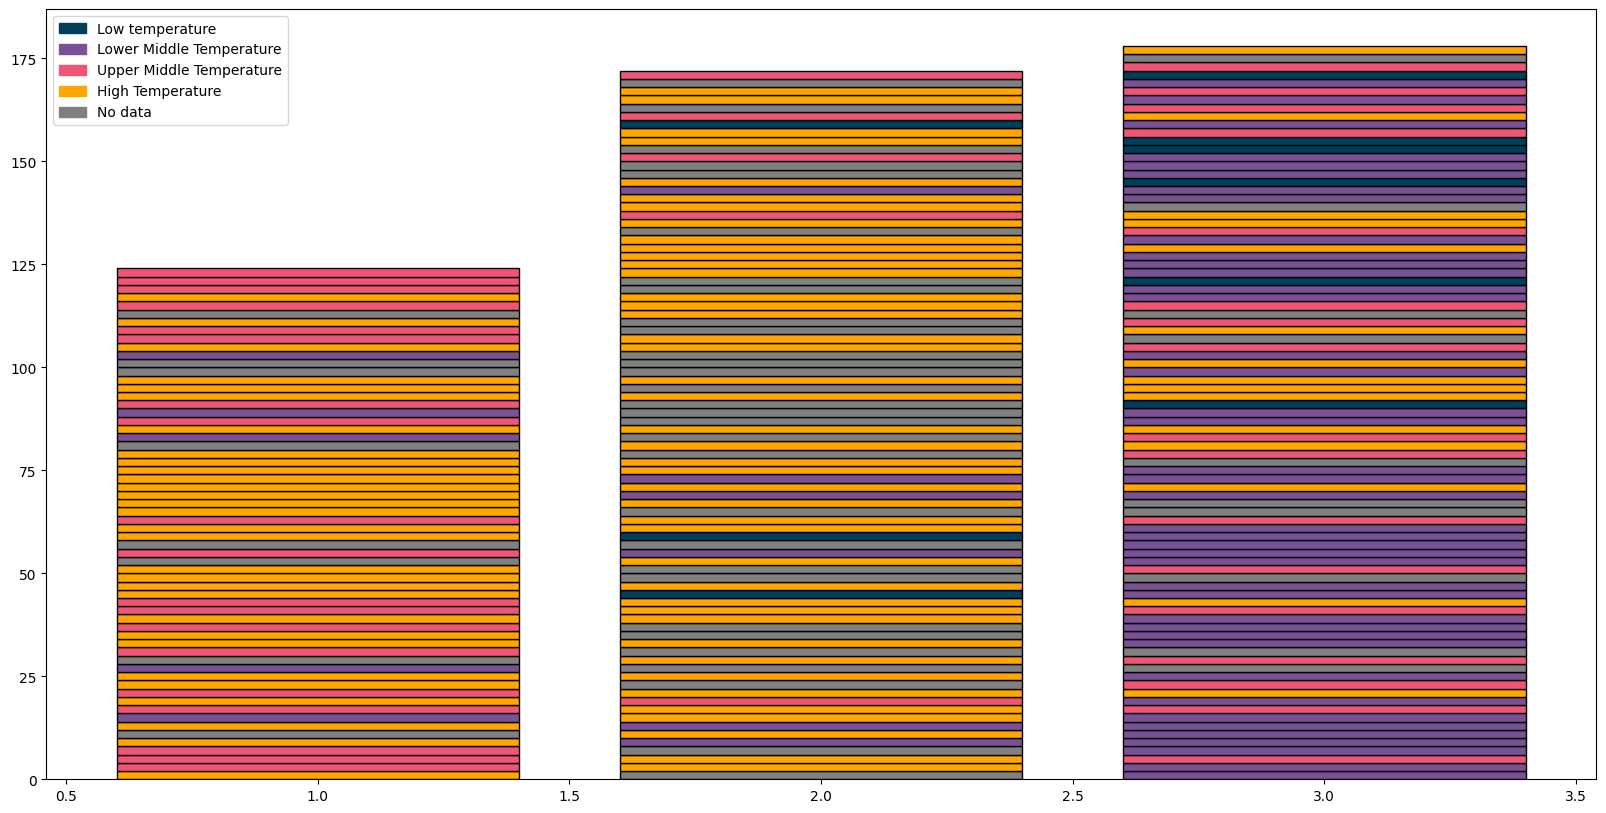

In [59]:
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if temp_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == "NaN":
                plt.bar(j+1, 2, color="#808080",width=0.8,edgecolor="#000000")
            h=2
        else:
            if temp_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == "NaN":
                plt.bar(j+1, 2, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Low temperature")
pop_b = mpatches.Patch(color='#7a5195', label="Lower Middle Temperature")
pop_c = mpatches.Patch(color='#ef5675', label="Upper Middle Temperature")
pop_d = mpatches.Patch(color='#ffa600', label='High Temperature')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])

In [52]:
for c in communities[12]:
    print(countries_swap[c],temp_dic[c])

Comoros 3
Suriname 3
Philippines 3
Indonesia 3
Liberia 3


# Data analyse

In [78]:
print(keywords[15])
print(len(keywords[15]))

marine fisheries traditional rights/customary rights fishing authorization allocation/quota fishery management and conservation
127


In [686]:
# Tæl hvor mange der er repealed inden for et dato interval
dates=data["Date of original text"]
repealed=data["Repealed"]
antal=0
for i in range(1800,2022):
    c=dates==str(i)
    d=repealed=="Y"
    antal+=sum(c*d)
print(antal)


0


In [ ]:
# Find number of extinct domains
a= list(set(data["Domain"]))
i=0
for words in a:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="Nan"
    a[i]=words.split(";")

    i+=1

In [ ]:
# print different domains
a=sum(a,[])
i=0
for word in a:
        word=word.strip()
        a[i]=word
        i+=1

print(set(a))



In [ ]:
# Count number documents in a language
languages=list(data["Language of document"])
print(languages.count("English"))

In [125]:
set(country)

{'Cameroon; Senegal',
 'Armenia; Azerbaijan; Belarus; Kazakhstan; Kyrgyzstan; Republic of Moldova; Russian Federation; Tajikistan; Turkmenistan; Uzbekistan; Ukraine',
 'European Union; Sao Tome and Principe',
 'Switzerland; Uzbekistan',
 'Russian Federation; Jordan',
 'Russian Federation; Saudi Arabia',
 'Portugal; Mozambique; Eswatini',
 'France; India',
 'Central African Republic',
 'Germany; Latvia',
 'Angola; Botswana; Democratic Republic of the Congo; Lesotho; Malawi; Mauritius; Mozambique; Namibia; Seychelles; South Africa; Eswatini; United Republic of Tanzania; Zambia; Zimbabwe',
 'Uruguay; Brazil',
 'Philippines; Indonesia',
 'Clipperton Island (France)',
 "Benin; Burkina Faso; Cameroon; Chad; Côte d'Ivoire; Guinea; Mali; Niger; Nigeria",
 'United States of America; American Samoa (USA)',
 'Senegal; United States of America',
 'Qatar',
 'China; Australia',
 'Papua New Guinea; Solomon Islands',
 'Cabo Verde; Japan',
 'Northern Mariana Islands (USA)',
 'United Kingdom of Great Br

- Cluster topics
- Dendogram